In [1]:
import pyspark
from pyspark import SparkContext
sc = SparkContext()

In [2]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext

In [3]:
url = "https://raw.githubusercontent.com/DannyTurpo/Proyecto/master/airqualitydata-2020.csv"
from pyspark import SparkFiles
sc.addFile(url)
sqlContext = SQLContext(sc)

In [4]:
df = sqlContext.read.csv(SparkFiles.get("airqualitydata-2020.csv"), header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [57]:
df.orderBy('Date').show(5, truncate = False)

+-------------------+-------+-------+------+-----+---+-----+------+--------+
|Date               |Country|City   |Specie|count|min|max  |median|variance|
+-------------------+-------+-------+------+-----+---+-----+------+--------+
|2019-12-30 00:00:00|CN     |Beijing|pm10  |403  |9.0|568.0|34.0  |10331.3 |
|2019-12-30 00:00:00|CN     |Jieyang|co    |147  |5.5|18.5 |10.9  |72.06   |
|2019-12-30 00:00:00|CN     |Beijing|co    |233  |0.8|8.2  |2.8   |16.76   |
|2019-12-30 00:00:00|CN     |Beijing|so2   |335  |0.6|3.1  |1.6   |3.27    |
|2019-12-30 00:00:00|CN     |Beijing|o3    |388  |8.6|28.1 |19.1  |78.93   |
+-------------------+-------+-------+------+-----+---+-----+------+--------+
only showing top 5 rows



# Seleccion de columnas
Para mostrar las filas con seleccion y los nombres de las entidades. A continuacion, se seleccionara Country, Specie y count 

In [7]:
df.select('Country','Specie','count').show()

+-------+----------+-----+
|Country|    Specie|count|
+-------+----------+-----+
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   23|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
|     BH|wind-speed|   24|
+-------+----------+-----+
only showing top 20 rows



A continuacion podemos contar el número de recurrencias por grupo, podemos encadenar: 
    - groupBy
    - count()
Para mostrar todas las filas, en show(), escribimos lo siguiente:
show(df.count(), truncate = False)
Se mostrara todas las variables que se estan midiendo en todas las ciudades. Algunas de estas ciudades no presentan todas las vaiables de la lista.

In [8]:
df.groupBy("Specie").count().sort("count",ascending=True).show(df.count(), truncate=False)

+-------------+-----+
|Specie       |count|
+-------------+-----+
|mepaqi       |159  |
|neph         |320  |
|pm1          |615  |
|pol          |715  |
|uvi          |1636 |
|aqi          |2251 |
|wd           |6359 |
|precipitation|8061 |
|wind-gust    |24178|
|wind gust    |28267|
|wind-speed   |42894|
|wind speed   |44075|
|co           |60137|
|so2          |65509|
|dew          |65557|
|o3           |72733|
|no2          |78214|
|pm10         |78523|
|pm25         |80814|
|pressure     |84477|
|humidity     |84729|
|temperature  |84751|
+-------------+-----+



Filtramos las especies correspondientes a Perú.

In [113]:
df.filter(df.Country == 'PE').groupBy("Specie").count().sort("count",ascending=True).show(df.count(), truncate=False)

+-----------+-----+
|Specie     |count|
+-----------+-----+
|wind-speed |71   |
|wind speed |73   |
|so2        |137  |
|o3         |137  |
|pm10       |137  |
|no2        |137  |
|co         |137  |
|pressure   |139  |
|humidity   |139  |
|dew        |139  |
|temperature|139  |
|pm25       |157  |
+-----------+-----+



# Resumen estadístico
Para obtener un resumen de las estadísticas de los datos, podemos usar describe(). Esto calcula:
    - conteo
    - mean
    - desviación estandar
    - mínimo
    - máximo

In [9]:
#df.describe().show()

Filtraremos el resumen estadístico solo para Perú.

In [115]:
df.filter(df.Country == 'PE').describe('Specie','count','min','max','median','variance').show()

+-------+----------+------------------+------------------+------------------+------------------+------------------+
|summary|    Specie|             count|               min|               max|            median|          variance|
+-------+----------+------------------+------------------+------------------+------------------+------------------+
|  count|      1542|              1542|              1542|              1542|              1542|              1542|
|   mean|      null| 67.02140077821012|104.46212710765255|134.38073929961084|113.04546044098589|1165.8714396887158|
| stddev|      null|31.947782405548335|285.66754964753045| 281.3671993236969|283.72464293154735| 3275.212599879645|
|    min|        co|                 6|               0.1|               2.5|               1.0|               0.0|
|    max|wind-speed|               164|            1013.5|            1016.5|            1014.8|           74203.2|
+-------+----------+------------------+------------------+--------------

El valor min se encuentra en la emisión de CO, mienstras que el max en wind-speed.

# Calculo de tabulacion cruzada
Podemos ver las estadisticas descriptivas entre dos columnas pareadas. Por ejemplo, podemos contar el numero de muestras que hay de cada Specie en cada país.

In [17]:
df.crosstab("Country","Specie").show(df.count(), truncate=False)

+--------------+----+----+----+--------+------+----+----+----+---+----+----+---+-------------+--------+----+-----------+----+----+---------+----------+---------+----------+
|Country_Specie|aqi |co  |dew |humidity|mepaqi|neph|no2 |o3  |pm1|pm10|pm25|pol|precipitation|pressure|so2 |temperature|uvi |wd  |wind gust|wind speed|wind-gust|wind-speed|
+--------------+----+----+----+--------+------+----+----+----+---+----+----+---+-------------+--------+----+-----------+----+----+---------+----------+---------+----------+
|VN            |16  |352 |615 |616     |0     |0   |518 |481 |0  |527 |685 |0  |108          |616     |251 |616        |0   |0   |5        |323       |10       |313       |
|IN            |0   |3461|3213|3218    |0     |0   |3475|3472|0  |3227|3627|0  |32           |3083    |3476|3224       |0   |142 |164      |1699      |360      |1636      |
|KW            |0   |0   |137 |138     |0     |0   |0   |0   |0  |0   |153 |0  |0            |138     |0   |138        |0   |0   |0    

# Filtrar datos
Podemos usar filter() para aplicar estadisticas descriptivas en un subconjunto de datos. Filtraremos los datos de Perú de toda la lista. En este caso para Specie pm1, pm10, pm25.

In [62]:
df.filter((df.Country == 'PE') & ((df.Specie == 'pm25') | (df.Specie == 'pm10') | (df.Specie == 'pm1'))).count()

294

Obtuvimos una cantidad de 294 datos, obtenidos en las fechas indicadas. Le asignaremos como un nuevo dataframe.

In [75]:
PEpm = df.filter((df.Country == 'PE') & ((df.Specie == 'pm25') | (df.Specie == 'pm10') | (df.Specie == 'pm1')))

La columna Date se nos muestra como varibale tipo timestamp, para convertirlo a tipo Date hacemos lo siguiente:

In [76]:
from pyspark.sql.types import *
PEpm = PEpm.withColumn("Date", PEpm["Date"].cast(DateType()))

In [77]:
PEpm.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



Como se observa se muestra como tipo Date. Ahora ordenaremos los datos primero por el tipo de Specie y luego por fecha. El dataframe solo nos muestra Specie pm10 y pm25, esto es debido a que no se cuenta con los valores de pm1 (no se hizo mediciones para estevalor). Ademas se seleciono solo los campor de Date, Country, City, Specie y count.

In [135]:
PEpm.orderBy('Specie','Date').select('Date','Country','City','Specie','count').show(PEpm.count(), truncate=False)

+----------+-------+----+------+-----+
|Date      |Country|City|Specie|count|
+----------+-------+----+------+-----+
|2019-12-30|PE     |Lima|pm10  |96   |
|2019-12-31|PE     |Lima|pm10  |96   |
|2020-01-01|PE     |Lima|pm10  |93   |
|2020-01-02|PE     |Lima|pm10  |95   |
|2020-01-03|PE     |Lima|pm10  |94   |
|2020-01-04|PE     |Lima|pm10  |87   |
|2020-01-05|PE     |Lima|pm10  |96   |
|2020-01-06|PE     |Lima|pm10  |96   |
|2020-01-07|PE     |Lima|pm10  |96   |
|2020-01-08|PE     |Lima|pm10  |96   |
|2020-01-09|PE     |Lima|pm10  |96   |
|2020-01-10|PE     |Lima|pm10  |95   |
|2020-01-11|PE     |Lima|pm10  |96   |
|2020-01-12|PE     |Lima|pm10  |96   |
|2020-01-13|PE     |Lima|pm10  |96   |
|2020-01-14|PE     |Lima|pm10  |96   |
|2020-01-15|PE     |Lima|pm10  |79   |
|2020-01-16|PE     |Lima|pm10  |71   |
|2020-01-17|PE     |Lima|pm10  |72   |
|2020-01-18|PE     |Lima|pm10  |72   |
|2020-01-19|PE     |Lima|pm10  |71   |
|2020-01-20|PE     |Lima|pm10  |71   |
|2020-01-21|PE     |Lima|

In [136]:
#from pyspark.sql.types import *
#PEpmnew = PEpm.withColumn("Date", PEpm["Date"].cast(DateType()))
#PEpmnew.printSchema()
#PEpmnew.orderBy('Date').show()

In [137]:
PEpm.filter(df.Specie == 'pm10').describe('Specie', 'count').show()

+-------+------+------------------+
|summary|Specie|             count|
+-------+------+------------------+
|  count|   137|               137|
|   mean|  null|100.94160583941606|
| stddev|  null| 20.14242173336343|
|    min|  pm10|                39|
|    max|  pm10|               120|
+-------+------+------------------+



In [138]:
PEpm.filter(df.Specie == 'pm25').describe('Specie', 'count').show()

+-------+------+-----------------+
|summary|Specie|            count|
+-------+------+-----------------+
|  count|   157|              157|
|   mean|  null|82.17834394904459|
| stddev|  null|43.05951504257164|
|    min|  pm25|               15|
|    max|  pm25|              143|
+-------+------+-----------------+



In [139]:
from pyspark.sql.functions import *
PEpm.filter(df.Specie == 'pm25').select(min("count")).first()
#PEpm['Specie'].max()

Row(min(count)=15)

In [140]:
from pyspark.sql.functions import *
PEpm.filter(df.Specie == 'pm25').select(max("count")).first()

Row(max(count)=143)

# Analisis para cada Specie Perú
A continuacíon se mostrará gráficas para las Species segun la fecha de medicíon.En este caso solo es esta tomando los valores para Perú.

# PM2.5 - PM10: 
Se denomina pm10 a las pequeñas partículas sólidas o líquidas de polvo, cenizas, hollín, partículas metálicas, cemento o polen, dispersas en la atmósfera, y cuyo diámetro aerodinámico es menor que 10 µm y a la fracción respirable más pequeña, PM2,5. Estas últimas están constituidas por aquellas partículas de diámetro aerodinámico inferior o igual a los 2,5 micrómetros, es decir, son 100 veces más delgadas que un cabello humano. Los efectos que las partículas causan en la salud de las personas han estado históricamente asociados a la exacerbación de enfermedades de tipo respiratorio, tales como la bronquitis, y más recientemente también se han analizado y demostrado sus efectos sobre dolencias de tipo cardiovascular.
https://www.ecologistasenaccion.org/17842/que-son-las-pm25-y-como-afectan-a-nuestra-salud/ //
https://www.ecologistasenaccion.org/5686/particulas-en-suspension-pm10/

Primero del dataframe solo tomaremos las columnas Country y Species, pero aplicando un filtro para solo mostrar los valores de Peú y pm10 - pm25.

In [153]:
PEpm10 = df.filter((df.Country == 'PE') & (df.Specie == 'pm10'))
PEpm10 = PEpm10.withColumn("Date", PEpm10["Date"].cast(DateType()))

DataFrame[Date: date, Country: string, City: string, Specie: string, count: int, min: double, max: double, median: double, variance: double]

In [174]:
PEpm10.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [191]:
PEpm25 = df.filter((df.Country == 'PE') & (df.Specie == 'pm25'))
PEpm25 = PEpm25.withColumn("Date", PEpm25["Date"].cast(DateType()))

In [183]:
PEpm10 = PEpm10.orderBy('Date').filter((df.Country == 'PE') & (df.Specie == 'pm10'))

In [192]:
PEpm10.show(PEpm10.count(), truncate=False)

+----------+-------+----+------+-----+----+-----+------+--------+
|Date      |Country|City|Specie|count|min |max  |median|variance|
+----------+-------+----+------+-----+----+-----+------+--------+
|2019-12-30|PE     |Lima|pm10  |96   |1.0 |108.0|23.0  |6705.01 |
|2019-12-31|PE     |Lima|pm10  |96   |1.0 |85.0 |28.0  |6465.92 |
|2020-01-01|PE     |Lima|pm10  |93   |1.0 |524.0|31.0  |57373.6 |
|2020-01-02|PE     |Lima|pm10  |95   |1.0 |78.0 |21.0  |4477.25 |
|2020-01-03|PE     |Lima|pm10  |94   |1.0 |92.0 |20.0  |5200.48 |
|2020-01-04|PE     |Lima|pm10  |87   |1.0 |87.0 |24.0  |5497.88 |
|2020-01-05|PE     |Lima|pm10  |96   |1.0 |91.0 |21.0  |4759.43 |
|2020-01-06|PE     |Lima|pm10  |96   |1.0 |86.0 |21.0  |4465.46 |
|2020-01-07|PE     |Lima|pm10  |96   |1.0 |67.0 |19.0  |3680.79 |
|2020-01-08|PE     |Lima|pm10  |96   |1.0 |103.0|21.0  |5561.86 |
|2020-01-09|PE     |Lima|pm10  |96   |1.0 |79.0 |22.0  |4787.56 |
|2020-01-10|PE     |Lima|pm10  |95   |1.0 |84.0 |25.0  |5743.4  |
|2020-01-1

In [194]:
PEpm25 = PEpm25.orderBy('Date').filter((df.Country == 'PE') & (df.Specie == 'pm25'))

In [195]:
PEpm25.show(PEpm25.count(), truncate=False)

+----------+-------+----+------+-----+----+-----+------+--------+
|Date      |Country|City|Specie|count|min |max  |median|variance|
+----------+-------+----+------+-----+----+-----+------+--------+
|2019-12-30|PE     |Lima|pm25  |48   |38.0|99.0 |63.0  |1830.0  |
|2019-12-31|PE     |Lima|pm25  |48   |30.0|109.0|63.0  |3237.41 |
|2020-01-01|PE     |Lima|pm25  |46   |43.0|174.0|65.0  |7367.27 |
|2020-01-02|PE     |Lima|pm25  |48   |38.0|89.0 |57.0  |1312.76 |
|2020-01-03|PE     |Lima|pm25  |48   |41.0|72.0 |53.0  |416.13  |
|2020-01-04|PE     |Lima|pm25  |39   |34.0|80.0 |57.0  |1234.29 |
|2020-01-05|PE     |Lima|pm25  |48   |42.0|82.0 |55.0  |651.27  |
|2020-01-06|PE     |Lima|pm25  |48   |38.0|68.0 |54.0  |496.02  |
|2020-01-07|PE     |Lima|pm25  |48   |25.0|64.0 |52.0  |753.4   |
|2020-01-08|PE     |Lima|pm25  |48   |34.0|76.0 |54.0  |779.72  |
|2020-01-09|PE     |Lima|pm25  |40   |30.0|78.0 |55.0  |841.63  |
|2020-01-10|PE     |Lima|pm25  |48   |42.0|112.0|64.0  |2265.21 |
|2020-01-1

In [200]:
PEpm10graf = PEpm10.orderBy('Specie','Date').select('Date','count')
PEpm25graf = PEpm25.orderBy('Specie','Date').select('Date','count')

Importamos pandas para poder realizar unas primeras graficas.

In [202]:
import pandas as pd
PEpm10pa = PEpm10graf.toPandas()
PEpm25pa = PEpm25graf.toPandas()
#import io
#import requests
#url="https://raw.githubusercontent.com/DannyTurpo/Proyecto/master/airqualitydata-2020.csv"
#s=requests.get(url).content
#covid = pd.read_csv(io.StringIO(s.decode('utf-8')))
#print(covid)
#covid
#covid['variance'].plot(kind='line')

Ahora vamos a transponer las filas y columnas.

In [203]:
PEpm10pa.T

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,96,96,93,95,94,87,96,96,96,96,...,120,117,120,120,119,120,120,120,119,72


In [204]:
PEpm25pa.T

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,48,48,46,48,48,39,48,48,48,48,...,120,120,120,120,119,120,120,120,120,74


Finalmente con el comando plot() podemos ver una grafica sobre la evolución de la concentración de pm10 y pm25 en todas las fechas de medición.

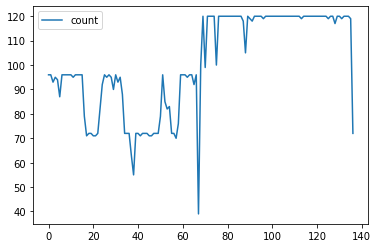

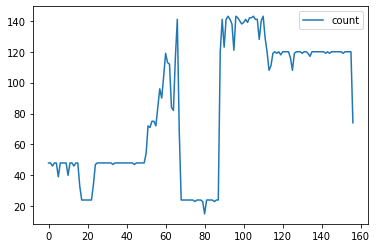

In [210]:
PEpm10pa.plot()
PEpm25pa.plot()

Para tener una mejor representación de estos datos podemos instalar plotly, una de las mejores librerías libres de uso para crear una variedad de gráficas responsivas, interactivas y ricas en funcionalidad.

In [170]:
! pip install plotly

     |████████████████████████████████| 11.5 MB 10.3 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=acbb6c213a2add0f61739d3f11d633623c98e693617060dbdde6e0311a77d973
  Stored in directory: /home/jovyan/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [215]:
import plotly.express as px
fig = px.line(PEpm10pa,x='Date',y='count',title="VALORES PARA PM10 POR FECHA")
fig.show()

In [217]:
import plotly.express as px
fig = px.line(PEpm25pa,x='Date',y='count',title="VALORES PARA PM25 POR FECHA")
fig.show()

Se puede observar que el día que se dió el primer caso de COVID-19 en Perú, la concentración de PM2.5 es de 68. El día que se decreto la cuarentena en Perú la concentración fue de 24, dando una baja importante durante el periodo de 12 días. Ocurre un incremento en el día 29 dando un valor de 120. Esto puede deberse a la extensión del periodo de cuarentena hasta el 12 de abril que se dio el 26 de marzo, provocando aglomeraciones en distintas zonas de Lima (ciudad en donde se toma las medidas). Este incremeneto tambien pudo observarse en la gráfica de pm10.

# SO2
El dióxido de azufre es uno de los gases mas comunmente liberados durante erupciones volcánicas (después de agua y dióxido carbónico), y es preocupante a escala global, debido a su potencial influencia en el clima. A escala global SO2 es peligroso para los humanos en su forma gaseosa y también porque se oxida formando sulfato aerosol. El dióxido de azufre es irritante a los ojos, garganta y vías respiratorias. La sobre exposición en el corto tiempo causa inflamación e irritación, provocando ardor en los ojos, tos, dificultades respiratorias y sensación de tensión en el pecho.
https://www.ivhhn.org/es/guidelines/guia-sobre-gases-volcanicos/dioxido-de-azufre#:~:text=Propiedades,2000%3B%20Wellburn%2C%201994).

In [218]:
PEso2 = df.filter((df.Country == 'PE') & (df.Specie == 'so2'))
PEso2 = PEso2.withColumn("Date", PEso2["Date"].cast(DateType()))

In [219]:
PEso2.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [220]:
PEso2 = PEso2.orderBy('Date').filter((df.Country == 'PE') & (df.Specie == 'so2'))

In [221]:
PEso2.show(PEso2.count(), truncate=False)

+----------+-------+----+------+-----+---+-----+------+--------+
|Date      |Country|City|Specie|count|min|max  |median|variance|
+----------+-------+----+------+-----+---+-----+------+--------+
|2019-12-30|PE     |Lima|so2   |24   |4.4|5.3  |4.7   |0.5     |
|2019-12-31|PE     |Lima|so2   |25   |4.3|173.0|4.9   |11314.7 |
|2020-01-01|PE     |Lima|so2   |24   |4.4|6.0  |4.7   |2.23    |
|2020-01-02|PE     |Lima|so2   |24   |4.3|5.0  |4.5   |0.33    |
|2020-01-03|PE     |Lima|so2   |23   |4.3|5.3  |4.5   |0.73    |
|2020-01-04|PE     |Lima|so2   |24   |4.1|4.9  |4.4   |0.63    |
|2020-01-05|PE     |Lima|so2   |24   |4.1|4.9  |4.3   |0.41    |
|2020-01-06|PE     |Lima|so2   |24   |4.1|5.0  |4.4   |0.38    |
|2020-01-07|PE     |Lima|so2   |24   |4.1|4.8  |4.3   |0.34    |
|2020-01-08|PE     |Lima|so2   |24   |4.4|5.4  |4.6   |1.09    |
|2020-01-09|PE     |Lima|so2   |24   |4.1|6.0  |4.6   |2.05    |
|2020-01-10|PE     |Lima|so2   |24   |4.3|5.8  |4.7   |1.45    |
|2020-01-11|PE     |Lima|

In [223]:
PEso2graf = PEso2.orderBy('Specie','Date').select('Date','count')
PEso2pa = PEso2graf.toPandas()

In [224]:
PEso2pa.T

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,24,25,24,24,23,24,24,24,24,24,...,72,72,72,72,71,72,72,72,72,44


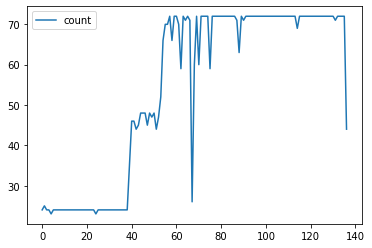

In [225]:
PEso2pa.plot()

In [226]:
fig1 = px.line(PEso2pa,x='Date',y='count',title="VALORES PARA SO2 POR FECHA")
fig1.show()

# CO
El monóxido de carbono (CO) es un gas mortal, sin color, sin olor y venenoso. Este es producido por combustibles tales como el carbón, la madera, el carbón vegetal, el aceite, el queroseno, el propano y el gas natural no se queman completamente. Los productos y aparatos de motor que queman combustible tales como los generadores portátiles, los automóviles, las podadoras de césped y las máquinas de lavado a presión también producen CO.

https://www.retema.es/articulo/entendiendo-el-origen-y-evolucion-del-monoxido-de-carbono-en-el-aire-que-respiramos-1AF4C#:~:text=Fuentes%20de%20CO%20en%20la,m%C3%A1s%20abundante%20y%20ampliamente%20distribuido.&text=En%20una%20atm%C3%B3sfera%20extremadamente%20limpia,de%20CO)%20%5B3%5D.

In [229]:
PEco = df.filter((df.Country == 'PE') & (df.Specie == 'co'))
PEco = PEco.withColumn("Date", PEco["Date"].cast(DateType()))
PEco.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [230]:
PEco = PEco.orderBy('Date').filter((df.Country == 'PE') & (df.Specie == 'co'))
PEco.show(PEco.count(), truncate=False)

+----------+-------+----+------+-----+---+-----+------+--------+
|Date      |Country|City|Specie|count|min|max  |median|variance|
+----------+-------+----+------+-----+---+-----+------+--------+
|2019-12-30|PE     |Lima|co    |72   |2.6|23.6 |13.9  |513.95  |
|2019-12-31|PE     |Lima|co    |79   |2.5|27.9 |13.6  |503.46  |
|2020-01-01|PE     |Lima|co    |93   |2.1|25.5 |11.2  |473.19  |
|2020-01-02|PE     |Lima|co    |102  |0.2|129.3|6.7   |4637.41 |
|2020-01-03|PE     |Lima|co    |99   |0.2|129.3|5.3   |4763.47 |
|2020-01-04|PE     |Lima|co    |102  |0.2|129.3|6.2   |4635.99 |
|2020-01-05|PE     |Lima|co    |99   |0.2|24.1 |5.1   |538.46  |
|2020-01-06|PE     |Lima|co    |99   |0.2|23.9 |5.2   |612.73  |
|2020-01-07|PE     |Lima|co    |99   |0.2|23.7 |5.3   |646.26  |
|2020-01-08|PE     |Lima|co    |99   |0.2|23.1 |4.8   |631.22  |
|2020-01-09|PE     |Lima|co    |99   |0.2|24.6 |6.5   |637.24  |
|2020-01-10|PE     |Lima|co    |99   |0.2|25.9 |5.1   |714.03  |
|2020-01-11|PE     |Lima|

In [231]:
PEcograf = PEco.orderBy('Specie','Date').select('Date','count')
PEcopa = PEcograf.toPandas()
PEcopa.T

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,72,79,93,102,99,102,99,99,99,99,...,78,75,78,78,70,72,72,72,72,30


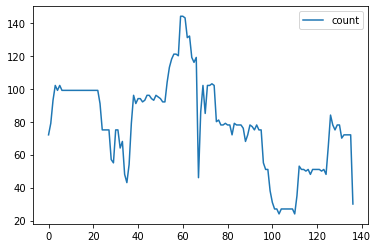

In [232]:
PEcopa.plot()

In [239]:
fig2 = px.line(PEcopa,x='Date',y='count',title="VALORES PARA CO POR FECHA")
fig2.show()

Se puede apreciar que los dias de cuarentena hubo una disminución en la concentración de CO en Lima. Se aprecia un incremento que coincide nuevamente con la extensión de los días de cuarentena, sin embargo hay una disminución apreciable en la concentración, el pico minimo es de 24 ppm.

# O3
La mayor parte del ozono presente en la atmósfera, entorno a un 90%, se encuentra en la estratosfera. Cuando se forma en la baja troposfera (capa más baja de la atmósfera) se denomina ozono troposférico y se considera un contaminante secundario de origen fotoquímico, pudiendo originar problemas en la salud, sobre todo en ciertos sectores sensibles, causando irritación en los ojos, nariz y garganta. Así, se han establecido relaciones entre la frecuencia de crisis de asma y los días de concentraciones elevadas de ozono y otros oxidantes fotoquímicos pues, al parecer, provoca una disminución de las funciones pulmonares. Los daños que provoca son extensibles también a la vegetación y a los materiales.

https://www.troposfera.org/conceptos/contaminantes-quimicos-de-la-atmosfera/Ozono/

In [240]:
PEo3 = df.filter((df.Country == 'PE') & (df.Specie == 'o3'))
PEo3 = PEo3.withColumn("Date", PEo3["Date"].cast(DateType()))
PEo3.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [241]:
PEo3 = PEo3.orderBy('Date').filter((df.Country == 'PE') & (df.Specie == 'o3'))
PEo3.show(PEo3.count(), truncate=False)

+----------+-------+----+------+-----+---+-----+------+--------+
|Date      |Country|City|Specie|count|min|max  |median|variance|
+----------+-------+----+------+-----+---+-----+------+--------+
|2019-12-30|PE     |Lima|o3    |48   |0.1|11.8 |3.1   |100.17  |
|2019-12-31|PE     |Lima|o3    |55   |0.2|11.3 |4.1   |121.03  |
|2020-01-01|PE     |Lima|o3    |70   |0.1|21.5 |3.9   |279.96  |
|2020-01-02|PE     |Lima|o3    |72   |0.3|12.9 |3.9   |89.67   |
|2020-01-03|PE     |Lima|o3    |69   |0.4|12.0 |4.8   |117.29  |
|2020-01-04|PE     |Lima|o3    |83   |0.3|25.5 |6.0   |456.93  |
|2020-01-05|PE     |Lima|o3    |96   |0.3|28.9 |7.2   |625.68  |
|2020-01-06|PE     |Lima|o3    |96   |0.3|27.2 |6.9   |606.24  |
|2020-01-07|PE     |Lima|o3    |96   |0.1|26.4 |6.4   |563.54  |
|2020-01-08|PE     |Lima|o3    |96   |0.3|24.1 |5.4   |549.51  |
|2020-01-09|PE     |Lima|o3    |96   |0.2|25.8 |5.3   |555.28  |
|2020-01-10|PE     |Lima|o3    |95   |0.4|25.0 |5.0   |524.06  |
|2020-01-11|PE     |Lima|

In [242]:
PEo3graf = PEo3.orderBy('Specie','Date').select('Date','count')
PEo3pa = PEo3graf.toPandas()
PEo3pa.T

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,48,55,70,72,69,83,96,96,96,96,...,96,95,89,90,92,87,79,83,93,57


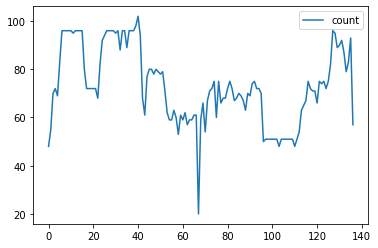

In [243]:
PEo3pa.plot()

In [244]:
fig3 = px.line(PEo3pa,x='Date',y='count',title="VALORES PARA O3 POR FECHA")
fig3.show()

En los días de cuarentena se vió un aumento significativo del ozono superficial, cercano a los valores de base de ozono superficial del planeta, como consecuencia de la disminución en la concentración de CO. El aumento en la cantidad de ozono está relacionado con la disminución de monóxido de carbono, debido a que estos gases reaccionan entre sí, y una menor concentración del CO produce un incremento en las concentraciones del O3.

In [246]:
fig2.show()
fig3.show()

In [265]:
PEall = df.filter((df.Country == 'PE') & ((df.Specie == 'o3') | (df.Specie == 'co')))
PEall = PEall.withColumn("Date", PEall["Date"].cast(DateType()))
PEall.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Specie: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- median: double (nullable = true)
 |-- variance: double (nullable = true)



In [266]:
PEall = PEall.orderBy('Specie','Date').filter((df.Country == 'PE'))
PEall.show(PEall.count(), truncate=False)

+----------+-------+----+------+-----+---+-----+------+--------+
|Date      |Country|City|Specie|count|min|max  |median|variance|
+----------+-------+----+------+-----+---+-----+------+--------+
|2019-12-30|PE     |Lima|co    |72   |2.6|23.6 |13.9  |513.95  |
|2019-12-31|PE     |Lima|co    |79   |2.5|27.9 |13.6  |503.46  |
|2020-01-01|PE     |Lima|co    |93   |2.1|25.5 |11.2  |473.19  |
|2020-01-02|PE     |Lima|co    |102  |0.2|129.3|6.7   |4637.41 |
|2020-01-03|PE     |Lima|co    |99   |0.2|129.3|5.3   |4763.47 |
|2020-01-04|PE     |Lima|co    |102  |0.2|129.3|6.2   |4635.99 |
|2020-01-05|PE     |Lima|co    |99   |0.2|24.1 |5.1   |538.46  |
|2020-01-06|PE     |Lima|co    |99   |0.2|23.9 |5.2   |612.73  |
|2020-01-07|PE     |Lima|co    |99   |0.2|23.7 |5.3   |646.26  |
|2020-01-08|PE     |Lima|co    |99   |0.2|23.1 |4.8   |631.22  |
|2020-01-09|PE     |Lima|co    |99   |0.2|24.6 |6.5   |637.24  |
|2020-01-10|PE     |Lima|co    |99   |0.2|25.9 |5.1   |714.03  |
|2020-01-11|PE     |Lima|

In [267]:
PEallgraf = PEall.orderBy('Specie','Date').select('Date','count')
PEallpa = PEallgraf.toPandas()
PEallpa.T

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,273
Date,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,...,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
count,72,79,93,102,99,102,99,99,99,99,...,96,95,89,90,92,87,79,83,93,57


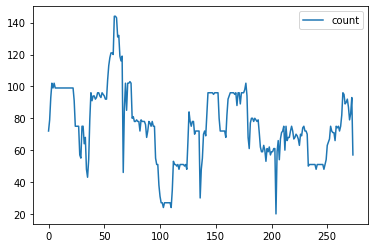

In [268]:
PEallpa.plot()

In [270]:
fig4 = px.line(PEallpa,x='Date',y='count',title="VALORES PARA O3 POR FECHA")
fig4.show()